## <span style="color:green"> Notebook - Melt Estimation - Simple Line Search and MCMC</span>
<span style="color:purple">Sinan Ozaydin, School of Geosciences, The University of Sydney, NSW 2006, Australia <br/> </span>
<span style="color:purple">sinan.ozaydin@protonmail.com | sinan.ozaydin@sydney.edu.au </span>

In this notebook, we will use experimental electrical conductivity measurements.

In [1]:
#Importing the neccesarry python libraries.
import os
import pide
from pide.inversion import conductivity_solver_single_param, conductivity_metropolis_hastings_two_param
from pide.imaging.plot_distribution import plot_posterior_distribution_two_params, plot_posterior_distribution_heatmap_two_params
import numpy as np
import matplotlib.pyplot as plt

/home/sinan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
p_obj = pide.pide()
melt_econd = p_obj.list_melt_econd_models()

Conductivity models for melts:
0.   Sifre2014_Wet_Carbonated
1.   Pommier2008_WetBasalt_Na
2.   Ni2011_WetBasalt
3.   Scarlato2004_DryBasalt_H1604
4.   TyburczyWaff1983_DryTholeiite
5.   TyburczyWaff1983_DryAndesite
6.   Guo2017_WetAndesite
7.   Laumonier2017_WetAndesite
8.   Laumonier2015_WetDacite
9.   Gaillard2004_WetRhyolite
10.   Guo2016_WetRhyolite
11.   Chen2018_WetGranite
12.   Guo2018_WetGranite
13.   Poe2008_Phonotephrite_Average
                 
                 


Melt fraction can be estimated for a given composition using the `conductivity_solver_single_param` function.  
Let's calculate the melt fraction corresponding to an electrical conductivity of **$10\ \Omega\cdot m$** (or **$0.1\ S/m$**) using the following parameters:

1. **Temperature and Pressure:**  
   - `1500 K` and `3 GPa`

2. **Solid matrix composition:**  
   - **Olivine (ol):** `0.6`  
   - **Orthopyroxene (opx):** `0.3`  
   - **Clinopyroxene (cpx):** `0.05`  
   - **Garnet:** `0.05`

3. **Solid minerals mixing method:**  
   - Hashin–Shtrikman Lower Bound

4. **Melt conductivity model:**  
   - Hydrous and carbonated melt model from **Sifre et al. (2014)**

5. **Melt CO₂ content:**  
   - `100 ppm` of **CO₂**

6. **Bulk water content:**  
   - `300 ppm` of **$OH^{-1}$**

7. **Melt/solid phase mixing model:**  
   - **Tubes model**
   
The `conductivity_solver_single_param` function estimates the fitting parameter using a simple **line-search algorithm**.  
In this example, we employ the following parameters:

1. **Parameter name (`param_name`):**  
   - Set to **`melt_fluid_mass_frac`**, which is the parameter to be estimated.

2. **Search bounds (`upper_limit_list` and `lower_limit_list`):**  
   - Define the upper and lower limits of the search space for the parameter.

3. **Initial step size (`search_start`):**  
   - Specifies the initial step size used in the line-search process.

4. **Acceptance threshold (`acceptance_threshold`):**  
   - Sets the acceptable error margin. If the total misfit is below this percentage of the input conductivity value, the solution is accepted and the line-search algorithm stops.

5. **Number of CPUs (`num_cpu`):**  
   - Indicates how many CPU cores will be used to parallelize the computation.



In [3]:
#setting up and environment at 1300 K and 3 GPa
temperature = np.array([1500])
pressure = np.array([3.0])

p_obj.set_temperature(temperature)
p_obj.set_pressure(pressure)

#setting up a simple lherzolite composition
p_obj.set_composition_solid_mineral(ol = 0.6,opx = 0.3, cpx = 0.05, garnet = 0.05)

#setting the mineral conductivity choices
#Ol - Gardes2014, Opx - Dai2009, Garnet: Dai2009, Cpx: Liu2019
p_obj.set_mineral_conductivity_choice(ol = 4, opx = 0, garnet = 0, cpx = 6)

#Setting up solid mineral mixing properties
p_obj.set_solid_phs_mix_method(1) #HS lower bound

#Setting up Sifre2014 as the conductivity choice
p_obj.set_melt_fluid_conductivity_choice(melt = 0)

#Setting up melt CO2
p_obj.set_melt_properties(co2 = 100)

#Setting up bulk water.
#Try to avoid setting up melt_h2o from set_melt properties, because this will not distribute water among minerals.
#Instead use mantle_water_distribute function after setting up the bulk water.
p_obj.set_bulk_water(300)
p_obj.mantle_water_distribute()

#Setting up the melt-solid mixture relationship to Tubes model
p_obj.set_solid_melt_fluid_mix_method(1)

#Setting up the conductivity value to estimate melt for
res_external = 10
cond_external = [1.0/res_external] #or 10 ohm m

#Now setting up the conductivity_solver_single_param
melt_frac_solution, residual_list = conductivity_solver_single_param(object = p_obj, cond_list = cond_external,
param_name = 'melt_fluid_mass_frac', upper_limit_list = np.ones(len(temperature)), lower_limit_list= np.zeros(len(temperature)),
search_start = 0.01, acceptence_threshold = 0.5, num_cpu = 1)
    
print(f'Melt mass fraction solution: {melt_frac_solution[0]*1e2}%')

Melt mass fraction solution: 24.500000000000004%


Now, let's solve for **melt fractions as a function of changing bulk water content**.  
We will set up the same environmental conditions as before: **1500 K** and **3 GPa**, and compute a series of solutions over a range of `bulk_water` values.

Since estimating melt fractions requires calculating **fluid density** at high pressure and temperature, **pide** uses the **Burnman** library to solve the melt composition equation of state (EOS) at each iteration — a computationally expensive process.

However, users can choose a simplified approach by setting `simplify_fluid_density` to **`True`**, which uses the **CoolProp** library for a faster, approximate fluid density calculation.  
While the solutions from these two methods will differ slightly, the differences are generally negligible and occur mostly at physically unreasonably small values of melt fractions.

In [4]:
p_obj = pide.pide()

#creating the temperature and pressure arrays
temperature = np.ones(100) * 1500
pressure = np.ones(100) * 3

#setting up bulk water arrays to be varied between 100 and 3000 ppm.
bulk_water_array = np.linspace(100,3000,100)

p_obj.set_temperature(temperature)
p_obj.set_pressure(pressure)

#setting up a simple lherzolite composition
p_obj.set_composition_solid_mineral(ol = 0.6,opx = 0.3, cpx = 0.05, garnet = 0.05)
#setting the mineral conductivity choices
p_obj.set_mineral_conductivity_choice(ol = 4, opx = 0, garnet = 0, cpx = 6)
p_obj.set_solid_phs_mix_method(1) #HS lower bound

#Setting up Sifre2014 as the conductivity choice
p_obj.set_melt_fluid_conductivity_choice(melt = 0)

#Setting up melt CO2
p_obj.set_melt_properties(co2 = 100)

#Setting up bulk water.
#Try to avoid setting up melt_h2o from set_melt properties, because this will not distribute water among minerals.
p_obj.set_bulk_water(bulk_water_array)
p_obj.mantle_water_distribute()

#Setting up the melt-solid mixture relationship to Tubes model
p_obj.set_solid_melt_fluid_mix_method(1)
p_obj.set_mantle_water_partitions(opx_melt = 1,cpx_melt = 1)

#converting resistivity to conductivity
cond_external = np.ones(len(temperature)) * (1.0/10.0)

#Now setting up the conductivity_solver_single_param
melt_frac_solution, residual_list = conductivity_solver_single_param(object = p_obj, cond_list = cond_external,
param_name = 'melt_fluid_mass_frac', upper_limit_list = np.ones(len(temperature)), lower_limit_list= np.zeros(len(temperature)),
search_start = 0.01, acceptence_threshold = 0.05, num_cpu = 1,simplify_fluid_density = False)




Now, we can plot the results with the following lines:

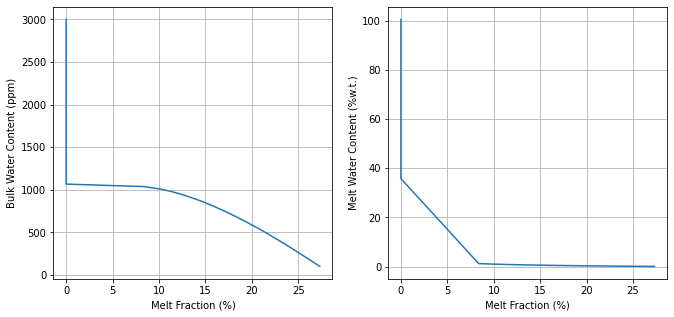

In [5]:
fig = plt.figure(figsize = (11,5))
ax = plt.subplot(121)
ax.plot(np.array(melt_frac_solution) * 1e2, bulk_water_array)
ax.set_xlabel('Melt Fraction (%)')
ax.set_ylabel('Bulk Water Content (ppm)')
ax.grid(which = 'both')

ax2 = plt.subplot(122)
ax2.plot(np.array(melt_frac_solution) * 1e2, p_obj.h2o_melt *1e-4)
ax2.set_xlabel('Melt Fraction (%)')
ax2.set_ylabel('Melt Water Content (%w.t.)')
ax2.grid(which = 'both')
plt.show()

Now, let's perform the same calculations using the **Markov Chain Monte Carlo (MCMC)** approach with the **Metropolis-Hastings** algorithm, implemented in the `conductivity_metropolis_hastings_two_param` function. This method generates a large number of proposed models, accepting or rejecting them based on a defined set of criteria. Depending on our previous line-search results we can also reduce the search space to be in between 7 percent melt fraction to above since silicic melts could not have much more water than approximately 10 wt.%.

The following parameters are used in this setup:

1. **Maximum values:(`upper_limits`)**  
   - **Water content** ($OH^{-1}$): limited to **3000 ppm**  
   - **Melt mass fraction**: limited to **0.5**  
   These limits are enforced during the algorithm to automatically reject any proposals that exceed them.

2. **Initial guesses: (`initial_params`)**
   - **Melt mass fraction**: `0.3`  
   - **Water content**: `1000 ppm`  
   These serve as the starting point for the algorithm. While they don't strongly influence the inversion results, they should still be within a reasonable range.

3. **Proposal step sizes (`proposal_std`):**  
   - **Melt mass fraction**: `0.25`  
   - **Water content**: `300 ppm`  
   These values control the magnitude of change in each proposed step. Larger step sizes allow broader exploration of the parameter space.

4. **Adaptive step size (`adaptive_alg`):**  
   - Set to **`True`**  
   - The algorithm adjusts step sizes dynamically based on the acceptance rate, aiming for a target between **0.2 and 0.3**.  
   - This range can be customized by the user by changing the parameter `ideal_acceptance_bounds`.
   - The adaptive

5. **Maximum step size limits:**  
   - **Water content**: `25000 ppm`  
   - **Melt fraction**: `0.5`  
   These define the upper bounds for the adaptive step sizes.

6. **Conductivity uncertainty (`sigma`):**  
   - Represents the **standard deviation of electrical conductivity** in **log units**  
   - Reflects the uncertainty in model estimation.

7. **Number of iterations (`n_iter`):**  
   - Total number of Monte Carlo iterations to be performed.

8. **Burn-in period (`burning`):**  
   - Number of initial iterations to discard.  
   - These early samples are excluded from the final distribution.


In [6]:
p_obj = pide.pide()

temperature = [1500]
pressure = [3]

p_obj.set_temperature(temperature)
p_obj.set_pressure(pressure)

#setting up a simple lherzolite composition
p_obj.set_composition_solid_mineral(ol = 0.6,opx = 0.3, cpx = 0.05, garnet = 0.05)
#setting the mineral conductivity choices
p_obj.set_mineral_conductivity_choice(ol = 4, opx = 0, garnet = 0, cpx = 6)
p_obj.set_solid_phs_mix_method(1) #HS lower bound

#Setting up Sifre2014 as the conductivity choice
p_obj.set_melt_fluid_conductivity_choice(melt = 0)

#Setting up melt CO2
p_obj.set_melt_properties(co2 = 100)

#Setting up the melt-solid mixture relationship to Tubes model
p_obj.set_solid_melt_fluid_mix_method(1)

p_obj.set_mantle_water_partitions(opx_melt = 1,cpx_melt = 1)

res_external = 10

#Bounds for the search space.
water_min = np.zeros(len(temperature))
water_max = 3000.0 * np.ones(len(temperature))
melt_min = 0.07 * np.ones(len(temperature))
melt_max = 0.5 * np.ones(len(temperature))

cond_external = [1.0/res_external]
initial_water = 1000
initial_melt = 0.3
initial_params = [[initial_water, initial_melt]]

sigma = 0.025 * np.ones(len(temperature))#in log
n_iterations = 300000
proposal_std = [200,0.25]
burning = 10000

samples, acceptance_rates, misfits, samples_all, misfits_all = conductivity_metropolis_hastings_two_param(object = p_obj, cond_list = cond_external,
initial_params = initial_params,param_name_1 = 'bulk_water',
param_name_2= "melt_fluid_mass_frac", upper_limits = (water_max,melt_max),
	lower_limits = (water_min,melt_min), sigma_cond = sigma,proposal_stds=proposal_std
	,n_iter = n_iterations, burning = burning, transition_zone = False,num_cpu = 1,adaptive_alg = True,
	step_size_limits = [25000,0.5])

water_samples = samples[0][:, 0]
melt_samples = samples[0][:, 1]

water_samples_all = samples_all[0][:, 0]
melt_samples_all = samples_all[0][:, 1]

Monte-Carlo loop is started
300000 total samples.
10000 burning samples.
Acceptence rate is good size: - Acceptance Rate: 0.282 - Completed :% 4
Acceptence rate is good size: - Acceptance Rate: 0.284 - Completed :% 5
Acceptence rate is good size: - Acceptance Rate: 0.286 - Completed :% 5
Acceptence rate is good size: - Acceptance Rate: 0.287 - Completed :% 5
Acceptence rate is good size: - Acceptance Rate: 0.29 - Completed :% 6
Acceptence rate is good size: - Acceptance Rate: 0.295 - Completed :% 6
Acceptence rate is good size: - Acceptance Rate: 0.295 - Completed :% 7
Acceptence rate is good size: - Acceptance Rate: 0.294 - Completed :% 7
Acceptence rate is good size: - Acceptance Rate: 0.294 - Completed :% 7
Acceptence rate is good size: - Acceptance Rate: 0.295 - Completed :% 8
Acceptence rate is good size: - Acceptance Rate: 0.294 - Completed :% 8
Acceptence rate is good size: - Acceptance Rate: 0.294 - Completed :% 9
Acceptence rate is good size: - Acceptance Rate: 0.293 - Complet

Acceptence rate is good size: - Acceptance Rate: 0.293 - Completed :% 47
Acceptence rate is good size: - Acceptance Rate: 0.293 - Completed :% 48
Acceptence rate is good size: - Acceptance Rate: 0.293 - Completed :% 48
Acceptence rate is good size: - Acceptance Rate: 0.293 - Completed :% 48
Acceptence rate is good size: - Acceptance Rate: 0.293 - Completed :% 49
Acceptence rate is good size: - Acceptance Rate: 0.293 - Completed :% 49
Acceptence rate is good size: - Acceptance Rate: 0.292 - Completed :% 49
Acceptence rate is good size: - Acceptance Rate: 0.293 - Completed :% 50
Acceptence rate is good size: - Acceptance Rate: 0.293 - Completed :% 51
Acceptence rate is good size: - Acceptance Rate: 0.293 - Completed :% 51
Acceptence rate is good size: - Acceptance Rate: 0.293 - Completed :% 52
Acceptence rate is good size: - Acceptance Rate: 0.293 - Completed :% 53
Acceptence rate is good size: - Acceptance Rate: 0.293 - Completed :% 54
Acceptence rate is good size: - Acceptance Rate: 0.

Acceptence rate is good size: - Acceptance Rate: 0.294 - Completed :% 91
Acceptence rate is good size: - Acceptance Rate: 0.294 - Completed :% 92
Acceptence rate is good size: - Acceptance Rate: 0.294 - Completed :% 92
Acceptence rate is good size: - Acceptance Rate: 0.294 - Completed :% 92
Acceptence rate is good size: - Acceptance Rate: 0.294 - Completed :% 93
Acceptence rate is good size: - Acceptance Rate: 0.294 - Completed :% 93
Acceptence rate is good size: - Acceptance Rate: 0.294 - Completed :% 95
Acceptence rate is good size: - Acceptance Rate: 0.294 - Completed :% 95
Acceptence rate is good size: - Acceptance Rate: 0.294 - Completed :% 95
Acceptence rate is good size: - Acceptance Rate: 0.294 - Completed :% 96
Acceptence rate is good size: - Acceptance Rate: 0.294 - Completed :% 96
Acceptence rate is good size: - Acceptance Rate: 0.294 - Completed :% 96
Acceptence rate is good size: - Acceptance Rate: 0.294 - Completed :% 97
Acceptence rate is good size: - Acceptance Rate: 0.

The **posterior distributions** can be visualized in two different ways using the built-in plotting functions in **pide**:

1. **`plot_posterior_distribution_two_params`**  
   - Generates histogram plots for the selected parameters, showing the distribution of accepted samples.

2. **`plot_posterior_distribution_heatmap_two_params`**  
   - Creates heatmaps representing the joint posterior distributions of the two parameters, providing a visual summary of parameter correlations.

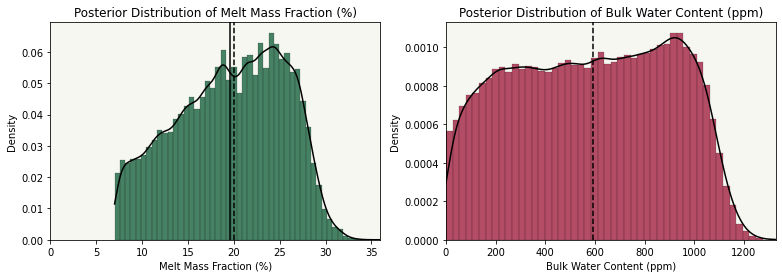

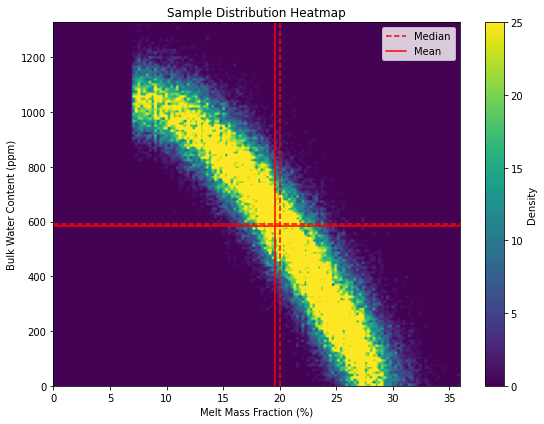

In [7]:
plot_posterior_distribution_two_params(data_param_1 = melt_samples*1e2,data_param_2 = water_samples,
                                    param1_name = 'Melt Mass Fraction (%)', param2_name = 'Bulk Water Content (ppm)',
                                    fig_size = (13,4),figsave = False)

plot_posterior_distribution_heatmap_two_params(data_param_1 = melt_samples*1e2,
data_param_2 = water_samples, param_1_min = 0, param_1_max = np.amax(melt_samples*1e2),
param_2_min = 0, param_2_max = np.amax(water_samples_all),
param1_name = 'Melt Mass Fraction (%)',
param2_name = "Bulk Water Content (ppm)",
file_name = f"melt_frac_solution.png",save = False)